In [17]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import seaborn as sns
from matplotlib import gridspec
import itertools
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import snow depth and all radar freeboard data
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
cs2_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])
cs2_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_LARM_full.nc')['Radar Freeboard'])
cs2s3_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_CPOM_full.nc')['Radar Freeboard'])
cs2s3_larm = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_LARM_full.nc')['Radar Freeboard'])

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020']

# 1 Oct - 30 Apr
cs2_days = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2464,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3194,3407), # 2018-2019
        np.arange(3560,3773) # 2019-2020
       ]

cs2s3_days = np.arange(3560,3773)

In [3]:
# function to calculate running mean, where T = np.int(number of days/2)

def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [4]:
### for safekeeping
winter_icetype = np.full(snow.shape,np.nan)
icetype = Dataset('/Users/carmennab/Dropbox/OI_Polarsnow/EASE/data/icetype.nc')['Ice Type']

for d in cs2_days:
    for day in d:
        it = icetype[day]
        it[(it!=2)&(it!=3)]=np.nan
        winter_icetype[day] = it
        
MYI_days = (winter_icetype == 3).sum(axis = 0).astype(np.float32)   
FYI_days = (winter_icetype == 2).sum(axis = 0).astype(np.float32)  

icetype_lon = Dataset('/Users/carmennab/Dropbox/OI_Polarsnow/EASE/data/icetype.nc')['Longitude']
icetype_lat = Dataset('/Users/carmennab/Dropbox/OI_Polarsnow/EASE/data/icetype.nc')['Latitude']
total = len(cs2_days[0])+len(cs2_days[1])+len(cs2_days[2])+len(cs2_days[3])+len(cs2_days[4])+len(cs2_days[5])+len(cs2_days[6])+len(cs2_days[7])+len(cs2_days[8])+len(cs2_days[9])
MYI_ave = MYI_days/total
FYI_ave = FYI_days/total

### calculate stats

In [5]:
thresh = 0.9 # icetype threshold

In [6]:
### CS2_CPOM & CS2_LARM
# this is gross code, sorry
CPOM_FYI = {}
CPOM_MYI = {}
cpom_ps = np.full((len(seasons),2),np.nan)
LARM_FYI = {}
LARM_MYI = {}
larm_ps = np.full((len(seasons),2),np.nan)
counters_y = np.arange(0,len(seasons))

fyis = [CPOM_FYI,LARM_FYI]
myis = [CPOM_MYI,LARM_MYI]
ps = [cpom_ps,larm_ps]
fbs = [cs2_cpom,cs2_larm]

for fyi,myi,pss,f in zip(fyis,myis,ps,fbs):

    for season, days, counter in zip(seasons, cs2_days, counters_y):
        
        fb = f[days]
        sm = snow[days]
        
#         FYI_ave, MYI_ave = icetypes()

        snow_FYI = np.full((len(days),snow.shape[1],snow.shape[2]),np.nan)
        snow_MYI = np.full((len(days),snow.shape[1],snow.shape[2]),np.nan)
        snow_mean_FYI = np.full(len(days),np.nan)
        snow_mean_MYI = np.full(len(days),np.nan)


        fb_FYI = np.full((len(days),snow.shape[1],snow.shape[2]),np.nan)
        fb_MYI = np.full((len(days),snow.shape[1],snow.shape[2]),np.nan)
        fb_mean_FYI = np.full(len(days),np.nan)
        fb_mean_MYI = np.full(len(days),np.nan)

        for day in np.arange(0,len(days)):
            snowz = sm[day]
            fbz = fb[day]

            # FYI
            a = snowz[FYI_ave > thresh]
            snow_mean_FYI[day] = np.nanmean(a)
            b = fbz[FYI_ave > thresh]
            fb_mean_FYI[day] = np.nanmean(b)

            # MYI
            a = snowz[MYI_ave > thresh]
            snow_mean_MYI[day] = np.nanmean(a)
            b = fbz[MYI_ave > thresh]
            fb_mean_MYI[day] = np.nanmean(b)

        snow_mean_FYI_smooth = runningmean(snow_mean_FYI,T=15)
        snow_mean_FYI_anom = runningmean(np.asarray(snow_mean_FYI) - np.asarray(snow_mean_FYI_smooth), T=4)
        fb_mean_FYI_smooth = runningmean(fb_mean_FYI,T=15)
        fb_mean_FYI_anom = runningmean(np.asarray(fb_mean_FYI) - np.asarray(fb_mean_FYI_smooth), T=4)

        snow_mean_MYI_smooth = runningmean(snow_mean_MYI,T=15)
        snow_mean_MYI_anom = runningmean(np.asarray(snow_mean_MYI) - np.asarray(snow_mean_MYI_smooth), T=4)
        fb_mean_MYI_smooth = runningmean(fb_mean_MYI,T=15)
        fb_mean_MYI_anom = runningmean(np.asarray(fb_mean_MYI) - np.asarray(fb_mean_MYI_smooth), T=4)

        snows = np.asarray(snow_mean_FYI_anom)
        freebs = np.asarray(fb_mean_FYI_anom)
        mask = ~np.isnan(snows) & ~np.isnan(freebs)
        rstats = pearsonr(snows[mask],freebs[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)

        fyi[season] = r
        pss[counter,0] = p

        snows = np.asarray(snow_mean_MYI_anom)
        freebs = np.asarray(fb_mean_MYI_anom)
        mask = ~np.isnan(snows) & ~np.isnan(freebs)
        
        try:
            rstats = pearsonr(snows[mask],freebs[mask])
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)

            myi[season] = r
            pss[counter,1] = p
            
        except:
            myi[season] = np.nan
            pss[counter,1] = np.nan   

In [11]:
### CS2S3_CPOM & CS2S3_LARM
CPOM_S3_FYI = {}
CPOM_S3_MYI = {}
cpom_s3_ps = np.full((1,2),np.nan)
LARM_S3_FYI = {}
LARM_S3_MYI = {}
larm_s3_ps = np.full((1,2),np.nan)

fyis = [CPOM_S3_FYI,LARM_S3_FYI]
myis = [CPOM_S3_MYI,LARM_S3_MYI]
ps = [cpom_s3_ps,larm_s3_ps]
fbs = [cs2s3_cpom,cs2s3_larm]

season = '2019-2020'

for fyi,myi,pss,f in zip(fyis,myis,ps,fbs):

    dayss = cs2s3_days
    fb = f[cs2s3_days]
    sm = snow[cs2s3_days]
    
#     FYI_ave, MYI_ave = icetypes()

    snow_FYI = np.full((len(cs2s3_days),snow.shape[1],snow.shape[2]),np.nan)
    snow_MYI = np.full((len(cs2s3_days),snow.shape[1],snow.shape[2]),np.nan)
    snow_mean_FYI = np.full(len(cs2s3_days),np.nan)
    snow_mean_MYI = np.full(len(cs2s3_days),np.nan)


    fb_FYI = np.full((len(cs2s3_days),snow.shape[1],snow.shape[2]),np.nan)
    fb_MYI = np.full((len(cs2s3_days),snow.shape[1],snow.shape[2]),np.nan)
    fb_mean_FYI = np.full(len(cs2s3_days),np.nan)
    fb_mean_MYI = np.full(len(cs2s3_days),np.nan)

    for day in range(len(cs2s3_days)):
        snowz=sm[day]
        fbz = fb[day]

        # FYI
        a = snowz[FYI_ave > thresh]
        snow_mean_FYI[day] = np.nanmean(a)
        b = fbz[FYI_ave > thresh]
        fb_mean_FYI[day] = np.nanmean(b)

        # MYI
        a = snowz[MYI_ave > thresh]
        snow_mean_MYI[day] = np.nanmean(a)
        b = fbz[MYI_ave > thresh]
        fb_mean_MYI[day] = np.nanmean(b)

    snow_mean_FYI_smooth = runningmean(snow_mean_FYI,T=15)
    snow_mean_FYI_anom = runningmean(np.asarray(snow_mean_FYI) - np.asarray(snow_mean_FYI_smooth), T=4)
    fb_mean_FYI_smooth = runningmean(fb_mean_FYI,T=15)
    fb_mean_FYI_anom = runningmean(np.asarray(fb_mean_FYI) - np.asarray(fb_mean_FYI_smooth), T=4)

    snow_mean_MYI_smooth = runningmean(snow_mean_MYI,T=15)
    snow_mean_MYI_anom = runningmean(np.asarray(snow_mean_MYI) - np.asarray(snow_mean_MYI_smooth), T=4)
    fb_mean_MYI_smooth = runningmean(fb_mean_MYI,T=15)
    fb_mean_MYI_anom = runningmean(np.asarray(fb_mean_MYI) - np.asarray(fb_mean_MYI_smooth), T=4)

    snows = np.asarray(snow_mean_FYI_anom)
    freebs = np.asarray(fb_mean_FYI_anom)
    mask = ~np.isnan(snows) & ~np.isnan(freebs)
    rstats = pearsonr(snows[mask],freebs[mask])
    r = np.round(rstats[0],decimals=2)
    p = np.round(rstats[1],decimals=3)

    fyi[season] = r
    pss[0,0] = p

    snows = np.asarray(snow_mean_MYI_anom)
    freebs = np.asarray(fb_mean_MYI_anom)
    mask = ~np.isnan(snows) & ~np.isnan(freebs)
    
    try:
        rstats = pearsonr(snows[mask],freebs[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)

        myi[season] = r
        pss[0,1] = p
        
    except:
        myi[season] = np.nan
        pss[0,1] = np.nan       

In [12]:
df_FYI_CPOM = pd.DataFrame.from_dict(CPOM_FYI, columns=[' '], orient = 'index')
df_MYI_CPOM = pd.DataFrame.from_dict(CPOM_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_CPOM,df_MYI_CPOM] 

df_combined_CPOM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)


df_FYI_LARM = pd.DataFrame.from_dict(LARM_FYI, columns=[' '], orient = 'index')
df_MYI_LARM = pd.DataFrame.from_dict(LARM_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_LARM,df_MYI_LARM] 

df_combined_LARM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

df_FYI_S3_CPOM = pd.DataFrame.from_dict(CPOM_S3_FYI, columns=[' '], orient = 'index')
df_MYI_S3_CPOM = pd.DataFrame.from_dict(CPOM_S3_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_S3_CPOM,df_MYI_S3_CPOM] 

df_combined_S3_CPOM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

df_FYI_S3_LARM = pd.DataFrame.from_dict(LARM_S3_FYI, columns=[' '], orient = 'index')
df_MYI_S3_LARM = pd.DataFrame.from_dict(LARM_S3_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_S3_LARM,df_MYI_S3_LARM] 

df_combined_S3_LARM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

### plot figure

In [13]:
%%capture output
x = plt.imshow(np.full((3,3),np.nan),vmin=-1,vmax=1,cmap='RdBu')

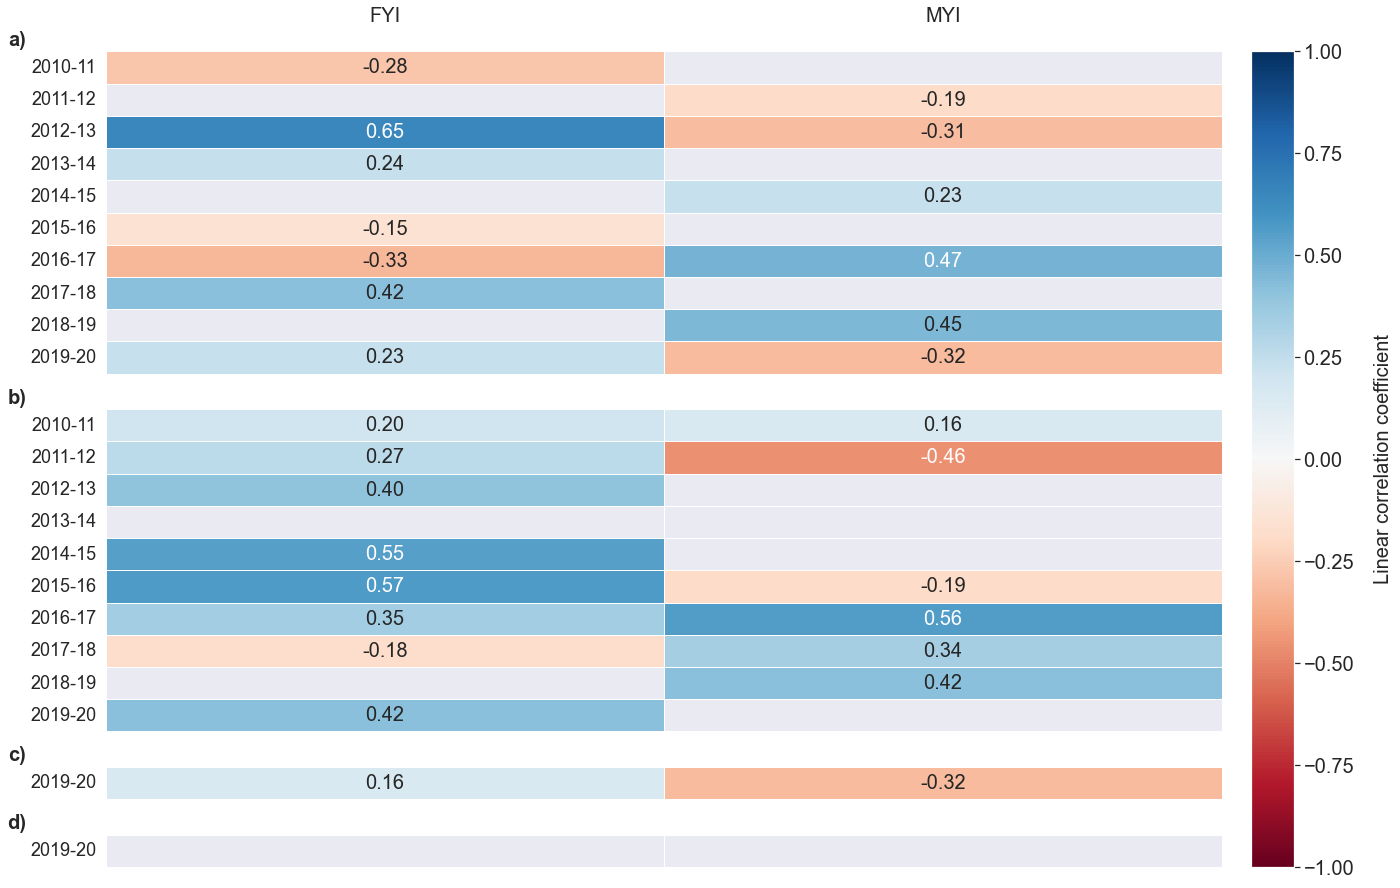

In [21]:
keys = ['FYI', 'MYI']
fig = plt.figure(figsize = (20,15))
spec = gridspec.GridSpec(ncols=1, nrows=4,
                         width_ratios=[1], wspace=0.5,
                         hspace=0.2, height_ratios=[10,10,1,1])

seasons = ['2010-11','2011-12','2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19',
          '2019-20']

# CS2_CPOM
ax1 = fig.add_subplot(spec[0])
mask = cpom_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax1 = sns.heatmap(df_combined_CPOM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax1.xaxis.tick_top()
ax1.set_xlabel(' ')    
ax1.set_yticklabels(seasons,rotation = 0,fontsize=18)
ax1.set_xticklabels(keys,fontsize=20,y=1.05)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True)
ax1.set_title('a)', x = -0.08,y = 1,fontweight="bold",fontsize=20)

# CS2_LARM
ax2 = fig.add_subplot(spec[1])
mask = larm_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax2 = sns.heatmap(df_combined_LARM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax2.set_xticks([])
ax2.set_xlabel(' ')
ax2.set_yticklabels(seasons,rotation = 0,fontsize=18)
ax2.set_title('b)', x = -0.08,y = 1,fontweight="bold",fontsize=20)

seasons = ['2019-20']
# CS2S3_CPOM
ax3 = fig.add_subplot(spec[2])
mask = cpom_s3_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax3 = sns.heatmap(df_combined_S3_CPOM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax3.set_xticks([])
ax3.set_xlabel(' ')
ax3.set_yticklabels(seasons,rotation = 0,fontsize=18)
ax3.set_title('c)', x = -0.08,y = 1,fontweight="bold",fontsize=20)

# CS2S3_LARM
ax4 = fig.add_subplot(spec[3])
mask = larm_s3_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax4 = sns.heatmap(df_combined_S3_LARM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax4.set_xticks([])
ax4.set_xlabel(' ')
ax4.set_yticklabels(seasons,rotation = 0,fontsize=18)
ax4.set_title('d)', x = -0.08,y = 1,fontweight="bold",fontsize=20)

cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
cb = fig.colorbar(x, cax=cbar_ax)
cb.set_label("Linear correlation coefficient",fontsize = 20,labelpad=20)
cb.ax.tick_params(labelsize=20)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/FYI_MYI_stats.png',bbox_inches = "tight")